In [657]:
%pdb on

import numpy as np

from google.colab import drive
drive.mount('/content/drive')

Automatic pdb calling has been turned ON
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Inicializando a Classe Agente**

In [658]:
"""An abstract class that specifies the Agent API for RL-Glue-py.
"""

from abc import ABCMeta, abstractmethod

class BaseAgent:

    """Implements the agent for an RL-Glue environment.
    Note:
        agent_init, agent_start, agent_step, agent_end, agent_cleanup, and
        agent_message are required methods.
    """

    __metaclass__ = ABCMeta


    def __init__(self):

        self.actions = None


    @abstractmethod
    def agent_init(self, agent_info = {}):

        """Setup for the agent called when the experiment first starts."""


    @abstractmethod
    def agent_start(self, state):

        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            observation (Numpy array): the state observation from the
            environment's evn_start function.
        Returns:
           T he first action the agent takes.
        """


    @abstractmethod
    def agent_step(self, reward, state):

        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken.
            observation (Numpy array): the state observation from the
                environment's step based, where the agent ended up after the
                last step.
        Returns:
            The action the agent is taking.
        """

# **Inicializando a Classe Ambiente**

In [659]:
"""Abstract environment base class for RL-Glue-py.
"""

from abc import ABCMeta, abstractmethod

class BaseEnvironment:

    """Implements the environment for an RLGlue environment.

    Note:
        env_init, env_start, env_step, env_cleanup, and env_message are required
        methods.
    """

    __metaclass__ = ABCMeta


    def __init__(self):

        self.state = None

        self.gridworld = None
        self.size = None


    @abstractmethod
    def env_init(self, env_info = {}):

        """Setup for the environment called when the experiment first starts.

        Note:
            Initialize a tuple with the reward, first state observation, boolean
            indicating if it's terminal.
        """


    @abstractmethod
    def env_start(self):

        """The first method called when the experiment starts, called before the
        agent starts.

        Returns:
            The first state observation from the environment.
        """


    @abstractmethod
    def env_step(self, action):

        """A step taken by the environment.

        Args:
            action: The action taken by the agent.

        Returns:
            (float, state, Boolean): a tuple of the reward, state observation,
                and boolean indicating if it's terminal.
        """

In [660]:
"""Glues together an experiment, agent, and environment.
"""

class RLGlue:

    """RLGlue class

    Args:
        env_name (string): the name of the module where the Environment class
        can be found.
        agent_name (string): the name of the module where the Agent class can be
        found.
    """

    def __init__(self, env_class, agent_class):

        self.environment = env_class()
        self.agent = agent_class()

        self.total_reward = None
        self.last_action = None
        self.num_steps = None
        self.num_episodes = None


    def rl_init(self, env_init_info={}, agent_init_info={}):

        """Initial method called when RLGlue experiment is created."""

        self.environment.env_init(env_init_info)
        agent_init_info['grid_size'] = self.environment.size
        self.agent.agent_init(agent_init_info)

        self.total_reward = 0.0
        self.num_steps = 0
        self.num_episodes = 0

    def rl_start(self, agent_start_info={}, env_start_info={}):

        """Starts RLGlue experiment.

        Returns:
            (state): last state observation.
        """

        self.last_state = self.environment.env_start()
        self.last_action = self.agent.agent_start(self.last_state)

        return

    def rl_episode_reinit(self, env_info = {}):

        """Restarts RLGlue episode."""

        self.environment.env_init(env_info)

        self.total_reward = 0.0
        self.num_steps = 0

    def rl_step(self, method):

        """Step taken by RLGlue, takes environment step and either step or
            end by agent.

        Returns:
            (float, state, action, Boolean): reward, last state observation,
                last action, boolean indicating termination.
        """

        (reward, next_state, done) = self.environment.env_step(self.last_action)

        self.total_reward += reward

        if done:
            self.num_episodes += 1
            next_action = None
            reward_laststate_lastaction_done = (reward, next_state, next_action,
                                                done)
        else:
            self.num_steps += 1
            next_action = self.agent.agent_step(reward, next_state)
            reward_laststate_lastaction_done = (reward, next_state,
                                                 next_action, done)

        if method == 'SARSA':
            #SARSA method
            self.agent.agent_SARSA_Q_update(self.last_state, self.last_action,
                                            next_state, next_action, reward)
        elif method == 'EXPECTEDSARSA':
            self.agent.agent_expected_SARSA_Q_update(self.last_state, self.last_action,
                                            next_state, reward)

        self.last_state = next_state
        self.last_action = next_action

        return reward_laststate_lastaction_done


    def rl_episode(self, max_steps_this_episode, method):

        """Runs an RLGlue episode.

        Args:
            max_steps_this_episode (Int): the maximum steps for the experiment
            to run in an episode.

        Returns:
            Boolean: if the episode should terminate.
        """

        is_terminal = False

        self.rl_start()

        while (not is_terminal) and (self.num_steps < max_steps_this_episode):

            print(f'\n Step: {self.num_steps + 1} - Action: {self.last_action} - Reward: {self.total_reward}\n')
            rl_step_result = self.rl_step(method)
            print(self.environment.gridworld)
            is_terminal = rl_step_result[3]

        if self.num_steps == max_steps_this_episode:
            self.num_episodes += 1

        return is_terminal


    def rl_return(self):

        """The total reward.

        Returns:
            float: the total reward.
        """

        return self.total_reward


    def rl_num_steps(self):

        """The total number of steps taken.

        Returns:
            Int: the total number of steps taken.
        """

        return self.num_steps


    def rl_num_episodes(self):

        """The number of episodes.

        Returns
            Int: the total number of episodes.

        """

        return self.num_episodes

# **Implementação do Agente com o método de aprendizado SARSA**

Para um ambiente Cliff-world de acordo com Sutton, o método on-policy SARSA possue melhor desempenho se comparado com o método off-policy Q-learning. O método Q-learning se arrisca mais pois aprende pela politica ótima (nesse caso, passando bem perto do penhasco), assim, isso resulta em diversas mortes do agente. Sarsa aprende de forma mais segura, aprende pelo caminho mais longo pela parte superior do grid.

Num ambiente cliff-world a melhor escolha de método de aprendizado entre SARSA, Q-learning e suas variações, é o SARSA.

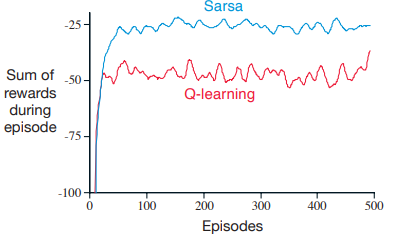

In [661]:
class CustomAgent(BaseAgent):

    def __init__(self):

        self.actions = ['left', 'right', 'up', 'down', 'stop']

        self.eps = 0.01
        self.alpha = 0.03
        self.gamma = 0.98

        self.Q = 0


    def agent_init(self, agent_info):

        self.Q = np.zeros((agent_info['grid_size'][0],agent_info['grid_size'][1],
                                                             len(self.actions)))

    def agent_start(self, state):

        if np.random.rand(1) < self.eps:

            return np.random.choice(self.actions)

        else:

            Q_actions = self.Q[state[0],state[1],:]
            maxQ = np.max(Q_actions)
            action = []
            for i in range(len(self.actions)):
                if Q_actions[i] == maxQ:
                    action.append(self.actions[i])

            return np.random.choice(action)

    def agent_step(self, reward, state):

        if np.random.rand(1) < self.eps:

            return np.random.choice(self.actions)

        else:
            Q_actions = self.Q[state[0], state[1],:]
            maxQ = np.max(Q_actions)
            action = []
            for i in range(len(self.actions)):
                if Q_actions[i] == maxQ:
                    action.append(self.actions[i])

            #return np.max(action)
            return np.random.choice(action)

    def agent_SARSA_Q_update(self, last_state, last_action, next_state,
                             next_action, reward):

        ind_last_action = self.actions.index(last_action)

        if next_action == None: # nao tem a componente ação-valor futura

            self.Q[last_state[0],last_state[1],ind_last_action] += \
                                                        self.alpha*(reward - \
                            self.Q[last_state[0],last_state[1],ind_last_action])

        else: # possui a ação-valor futura

            ind_next_action = self.actions.index(next_action)

            self.Q[last_state[0],last_state[1],ind_last_action] += \
                                            self.alpha*(reward + self.gamma * \
                      self.Q[next_state[0],next_state[1],ind_next_action] - \
                      self.Q[last_state[0],last_state[1],ind_last_action])

    def agent_expected_SARSA_Q_update(self, last_state, last_action, next_state, reward):

        ind_last_action = self.actions.index(last_action)
        Q_next = self.Q[next_state[0], next_state[1], :]

        ## Calcular a política epsilon-greedy para o próximo estado
        maxQ = np.max(Q_next)
        greedy_actions = [a for a in self.actions if Q_next[self.actions.index(a)] == maxQ]
        num_greedy_actions = len(greedy_actions)

        policy = np.ones(len(self.actions)) * (self.eps / len(self.actions))
        for a in greedy_actions:
            policy[self.actions.index(a)] += (1 - self.eps) / num_greedy_actions

        expected_Q = np.sum(policy * Q_next)

        # Atualização do valor Q
        self.Q[last_state[0], last_state[1], ind_last_action] += self.alpha * \
            (reward + (self.gamma * expected_Q) - self.Q[last_state[0], last_state[1], ind_last_action])


Pensamos em implementar o método expected sarsa por ter uma perfomance um pouco melhor que o SARSA e Q-Learning para um grid cliff-world. O método expected é mais complexo computacionalmente porém elimina a variância devido a seleção da próxima ação presente no método SARSA. Fizemos alguns testes com o método expected sarsa, porém não obtemos um treinamento satisfatorio, talvez devessemos modificar os parametros mais algumas vezes. Em Sutton, é possível ver uma comparação do expected sarsa com os demais métodos variando a taxa alpha.

Também não temos certeza do código da atualização da função valor Q desse método, nos baseamos pelo livro Sutton.

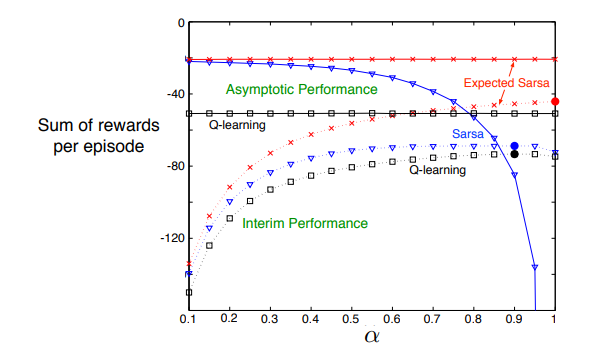
























# **Implementação do Cliff World com portas e uma chave**

In [662]:
class CustomEnvironment(BaseEnvironment):

    def __init__(self):
        self.state = 0
        self.size = 0

        self.door_locator = 1
        self.agent_locator = 2
        self.goal_locator = 3
        self.cliff_locator = 4
        self.key_locator = 9

        self.agent_dead = None

        done = False

        #Grid
        #self.gridworld = np.array([
        #    [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
        #    [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        #    [0, 0, 1, 0, 9, 0, 0, 0, 0, 1, 0, 0],
        #    [0, 0, 4, 4, 4, 4, 4, 4, 0, 0, 0, 1],
        #    [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3]
        #])

    def env_init(self, env_info):

        self.key = False

        with open(env_info['gridworld_pathfile'],'r') as file:
            data = file.readlines()

        data_mod = []
        for line in data:
            if line[0] == '#':
                continue
            else:
                data_mod.append(list(map(int,line[:-1].split(sep = ' '))))

        self.gridworld = np.array(data_mod[1:])
        self.size = (tuple(data_mod[0]))

        self.state = []
        agent_position =  np.where(self.gridworld == self.agent_locator)
        for _ in agent_position:
            self.state.append(_.tolist()[0])

        self.agent_dead = False

        print("The GRIDWORLD read was:\n")
        print(self.gridworld,'\n')

    def env_start(self):
        return self.state.copy()

    def env_step(self, action):

        if action == 'left' and self.state[1] != 0:

            if self.key == True: # tem a chave, então passa pelas portas

                #verifica se é porta
                if self.gridworld[self.state[0], self.state[1] - 1] == \
                            self.door_locator and self.state[1] - 1 != 0 and self.gridworld[self.state[0], self.state[1] - 2] != self.door_locator:
                    self.gridworld[self.state[0], self.state[1]] = 0
                    self.state[1] -= 2
                elif self.gridworld[self.state[0], self.state[1] - 1] == \
                            self.door_locator and self.state[1] - 1 != 0 and self.gridworld[self.state[0], self.state[1] - 2] == self.door_locator:
                    pass
                elif self.gridworld[self.state[0], self.state[1] - 1] == \
                                                self.door_locator and \
                                                         self.state[1] - 1 == 0:
                    pass
                else:
                    self.gridworld[self.state[0], self.state[1]] = 0
                    self.state[1] -= 1

            else:

                #verifica se é porta
                if self.gridworld[self.state[0], self.state[1] - 1] == \
                                                              self.door_locator:
                    pass
                else:
                    self.gridworld[self.state[0], self.state[1]] = 0
                    self.state[1] -= 1

        elif action == 'right' and self.state[1] != self.size[1] - 1:

            if self.key == True:
            #verifica se é porta
                if self.gridworld[self.state[0], self.state[1] + 1] == \
                                                         self.door_locator and \
                                          self.state[1] + 1 != self.size[1] - 1 and self.gridworld[self.state[0], self.state[1] + 2] != self.door_locator:
                    self.gridworld[self.state[0], self.state[1]] = 0
                    self.state[1] += 2

                elif self.gridworld[self.state[0], self.state[1] + 1] == \
                                                         self.door_locator and \
                                          self.state[1] + 1 != self.size[1] - 1 and self.gridworld[self.state[0], self.state[1] + 2] != self.door_locator:
                    pass

                elif self.gridworld[self.state[0], self.state[1] + 1] == \
                                                         self.door_locator and \
                                          self.state[1] + 1 == self.size[1] - 1:
                    pass
                else:
                    self.gridworld[self.state[0], self.state[1]] = 0
                    self.state[1] += 1

            else:

                #verifica se é porta
                if self.gridworld[self.state[0], self.state[1] + 1] == \
                                                              self.door_locator:
                    pass

                else:
                    self.gridworld[self.state[0], self.state[1]] = 0
                    self.state[1] += 1


        elif action == 'up' and self.state[0] != 0:

            if self.key == True:
            #verifica se é porta
                if self.gridworld[self.state[0] - 1, self.state[1]] == \
                                                         self.door_locator and \
                                                         self.state[0] - 1 != 0 and self.gridworld[self.state[0] - 2, self.state[1]] != self.door_locator:
                    self.gridworld[self.state[0], self.state[1]] = 0
                    self.state[0] -= 2

                elif self.gridworld[self.state[0] - 1, self.state[1]] == \
                                                         self.door_locator and \
                                                         self.state[0] - 1 != 0 and self.gridworld[self.state[0] - 2, self.state[1]] == self.door_locator:
                    pass

                elif self.gridworld[self.state[0] - 1, self.state[1]] == \
                                                         self.door_locator and \
                                                         self.state[0] - 1 == 0:
                    pass

                else:
                    self.gridworld[self.state[0], self.state[1]] = 0
                    self.state[0] -= 1

            else:

                #verifica se é porta
                if self.gridworld[self.state[0] - 1, self.state[1]] == \
                                                              self.door_locator:
                    pass

                else:
                    self.gridworld[self.state[0], self.state[1]] = 0
                    self.state[0] -= 1


        elif action == 'down' and self.state[0] != self.size[0] - 1:

            if self.key == True:
            #verifica se é porta
                if self.gridworld[self.state[0] + 1, self.state[1]] == \
                                                         self.door_locator and \
                                          self.state[0] + 1 != self.size[0] - 1 and self.gridworld[self.state[0] + 2, self.state[1]] != self.door_locator:
                    self.gridworld[self.state[0], self.state[1]] = 0
                    self.state[0] += 2

                elif self.gridworld[self.state[0] + 1, self.state[1]] == \
                                                         self.door_locator and \
                                          self.state[0] + 1 != self.size[0] - 1 and self.gridworld[self.state[0] + 2, self.state[1]] == self.door_locator:
                    pass

                elif self.gridworld[self.state[0] + 1, self.state[1]] == \
                                                         self.door_locator and \
                                          self.state[0] + 1 == self.size[0] - 1:
                    pass
                else:
                    self.gridworld[self.state[0], self.state[1]] = 0
                    self.state[0] += 1

            else:

                #verifica se é porta
                if self.gridworld[self.state[0] + 1, self.state[1]] == \
                                                              self.door_locator:
                    pass

                else:
                    self.gridworld[self.state[0], self.state[1]] = 0
                    self.state[0] += 1


        elif action == 'stop':
            reward = -1
            pass

        if self.gridworld[self.state[0], self.state[1]] == self.cliff_locator:
            reward = -100      #cair do penhasco
            done = True
            self.agent_dead = True

        elif self.gridworld[self.state[0], self.state[1]] == self.goal_locator:
            reward = -1     #alcancar objetivo
            done = True

        elif self.gridworld[self.state[0], self.state[1]] == self.key_locator:
            reward = +5
            self.key = True
            done = False

        else:
            reward = -1    #por dar um passo em direcao vazia
            done = False

        self.gridworld[self.state[0], self.state[1]] = self.agent_locator

        return (reward, self.state.copy(), done)

Depois de diversos testes com diversos valores das taxas de aprendizado, etc. os valores de alpha, eps e gamma com melhor performance visualizada foram os que estão presentes no código. Com o método Expected Sarsa não foram testados valores suficientes.

No metodo SARSA é possível visualizar que com +5 de recompensa na chave, o agente busca pegar a chave no ínicio de cada episodio, ja no método expected sarsa, isso demora um pouco mais.

# **Experimento**

In [663]:
# Rl glue com ambiente e o agente
experiment = RLGlue(CustomEnvironment, CustomAgent)

env_init_info = {'gridworld_pathfile':
                 '/content/drive/MyDrive/ColabNotebooks/gridWorld_cliffWalking_key.txt'}
# inicia rl glue
experiment.rl_init(env_init_info, agent_init_info={})

# num ep e num de passos
num_episodes = 700
num_steps = 400

episodes_totalreward = []
episodes_totalsteps = []

count_finish = 0
count_not_finish = 0
count_died = 0

method = 'EXPECTEDSARSA'

# loop dos episodios
for episode in range(num_episodes):
    print(f'\nEpisode: {episode + 1}')

    terminated = experiment.rl_episode(num_steps, method)
    if terminated and not experiment.environment.agent_dead:
        goal = True
        count_finish += 1
    elif experiment.environment.agent_dead:
        goal = False
        count_died += 1
        count_not_finish += 1
    else:
        goal = False
        count_not_finish += 1

    print(f'\n End of Episode {episode + 1}: Agent found the goal -> {goal}\n')

    episodes_totalreward.append(experiment.rl_return())
    episodes_totalsteps.append(experiment.rl_num_steps())

    if experiment.num_episodes < num_episodes:
        experiment.rl_episode_reinit(env_init_info)

Streaming output truncated to the last 5000 lines.
 Step: 45 - Action: up - Reward: -33.0

[[0 0 0 2 0 1 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 1 0 1 0]
 [0 0 1 0 0 0 0 0 0 1 0 0]
 [0 0 4 4 4 4 4 4 0 0 1 0]
 [0 4 4 4 4 4 4 4 4 4 4 3]]

 Step: 46 - Action: up - Reward: -34.0

[[0 0 0 2 0 1 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 1 0 1 0]
 [0 0 1 0 0 0 0 0 0 1 0 0]
 [0 0 4 4 4 4 4 4 0 0 1 0]
 [0 4 4 4 4 4 4 4 4 4 4 3]]

 Step: 47 - Action: right - Reward: -35.0

[[0 0 0 0 2 1 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 1 0 1 0]
 [0 0 1 0 0 0 0 0 0 1 0 0]
 [0 0 4 4 4 4 4 4 0 0 1 0]
 [0 4 4 4 4 4 4 4 4 4 4 3]]

 Step: 48 - Action: down - Reward: -36.0

[[0 0 0 0 0 1 0 1 0 0 0 0]
 [0 0 0 1 2 0 0 0 1 0 1 0]
 [0 0 1 0 0 0 0 0 0 1 0 0]
 [0 0 4 4 4 4 4 4 0 0 1 0]
 [0 4 4 4 4 4 4 4 4 4 4 3]]

 Step: 49 - Action: down - Reward: -37.0

[[0 0 0 0 0 1 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 1 0 1 0]
 [0 0 1 0 2 0 0 0 0 1 0 0]
 [0 0 4 4 4 4 4 4 0 0 1 0]
 [0 4 4 4 4 4 4 4 4 4 4 3]]

 Step: 50 - Action: up - Reward: -38.0

[[0 0 0 0 0 1 0 1

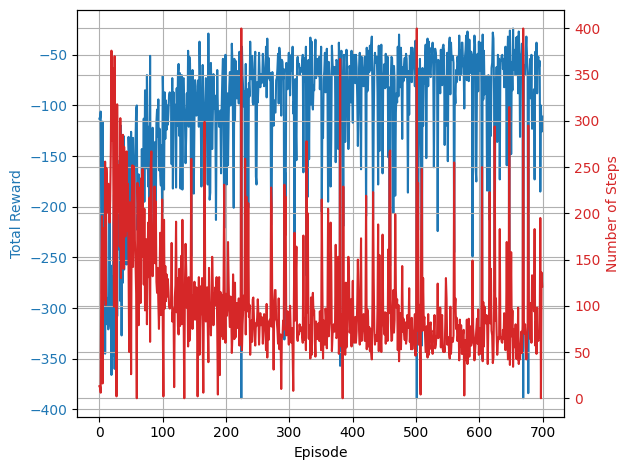

In [664]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward', color=color)
ax1.plot(episodes_totalreward, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()

ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('Number of Steps', color=color)
ax2.plot(episodes_totalsteps, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid()

fig.tight_layout()

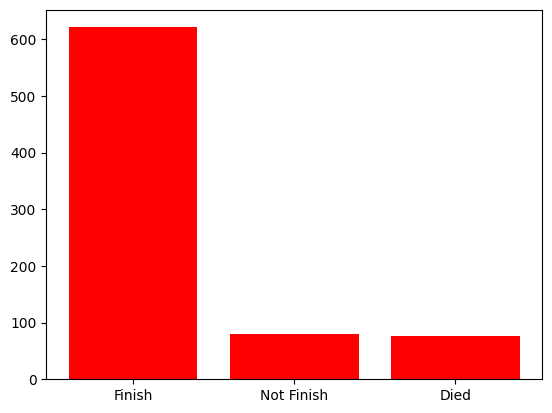

In [665]:
import matplotlib.pyplot as plt

x1 = ['Finish', 'Not Finish', 'Died']
y1 = [count_finish, count_not_finish, count_died]
plt.bar(x1, y1, color='red')
plt.show()